# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

## Подготовка данных

### Открытие и изучение данных

In [1]:
# загрузим библиотеки для работы
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
# загрузим данные
data = pd.read_csv("/datasets/autos.csv")

In [3]:
# изучим структуру таблицы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# посмотрим 5 строк таблицы
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# посмотрим на статистические данные
data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [6]:
# проверим дубликаты
print('Количество дубликатов:', sum(data.duplicated()))

Количество дубликатов: 4


In [7]:
missing_data = {'К-во пропусков': data.isna().sum().sort_values(), 'Доля пропусков, %': data.isna().sum().sort_values() / len(data) * 100}
pd.DataFrame(missing_data)


,К-во пропусков,"Доля пропусков, %"
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000
RegistrationMonth,0,0.000000
Brand,0,0.000000
DateCreated,0,0.000000
NumberOfPictures,0,0.000000
PostalCode,0,0.000000


В итоге имеем:
- данные содержат 354 тыс.записей
- наличие пропусков в данных от 5,6 до 20% в категориальных данных
- 4 дубликата, которые удалим при обработке
- данные в `DateCrawled` и в `DateCreated` повторяют друг друга и для оценки стоимости авто они вряд ли понадобятся, удалим их
- признаки `NumberOfPictures`, `PostalCode`, `LastSeen` и `	RegistrationMonth` не влияют на расчет стоимости автомобиля, их можно будет удалить
- в данных есть нулевые значения по цене и мощности автомобиля
- в `RegistrationYear` и в `Power` есть аномальные значения (например, 1000 год - мин. год регистрации, 9999 год, как максимальный или 20000 л.с. - макс. мощность автомобиля), нужно будет отчистить данные от явных выбросов

### Предобработка данных

In [8]:
# удалим дубликаты в данных
data = data.drop_duplicates()
print('Количество дубликатов:', sum(data.duplicated()))

Количество дубликатов: 0


In [9]:
# удалим лишние столбцы
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCreated'], axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   NotRepaired       283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


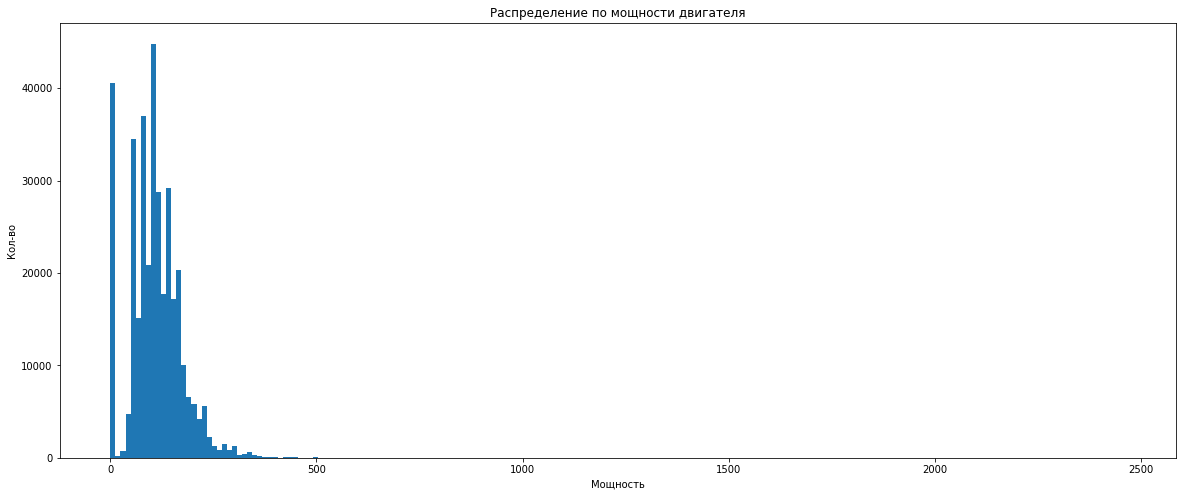

In [10]:
# построим гистограмму по мощности, чтобы посмотреть на выбросы
data[data['Power'] < 2500]['Power'].plot(kind='hist', bins=200, figsize=(20,8))
plt.title('Распределение по мощности двигателя')
plt.xlabel('Мощность')
plt.ylabel('Кол-во');

Все значения больше 500 можно считать выбросами. Есть также большое кол-во нулевых значений

Посчитаем кол-во выбросов и нулевых значений в данных

In [11]:
print('Количество нулевых значений по цене:', data[data['Price'] == 0]['Price'].count())
print('Количество нулевых значений по мощности:', data[data['Power'] == 0]['Power'].count())
print('Мощность более 500:', data[data['Power'] > 500]['Power'].count())
print('Год регистрации ранее 1950:', data[data['RegistrationYear'] < 1950]['RegistrationYear'].count())
print('Год регистрации позже 2022:', data[data['RegistrationYear'] > 2022]['RegistrationYear'].count())


Количество нулевых значений по цене: 10772
Количество нулевых значений по мощности: 40225
Мощность более 500: 459
Год регистрации ранее 1950: 246
Год регистрации позже 2022: 105


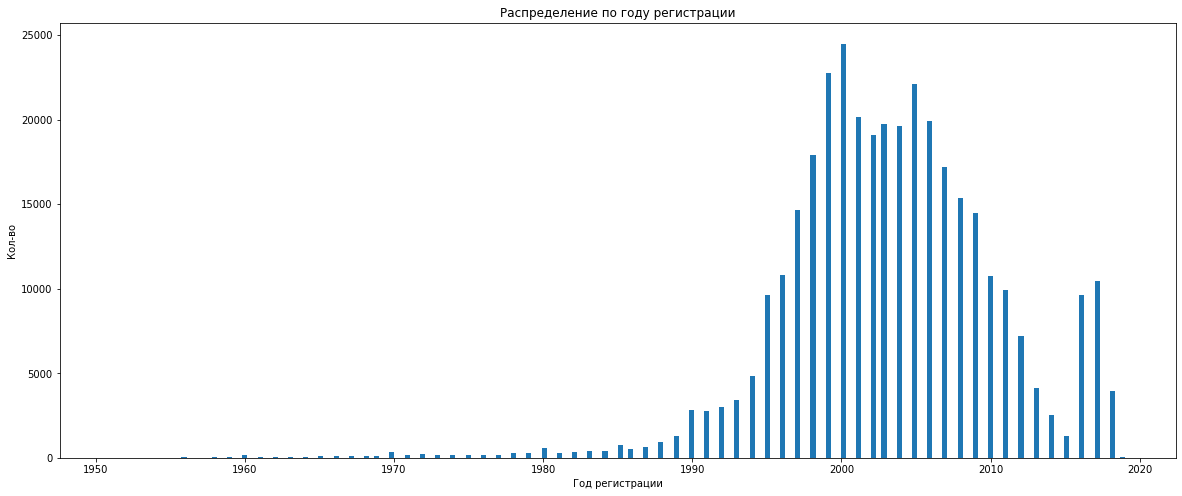

In [12]:
# построим гистограмму по мощности, чтобы посмотреть на выбросы
data[(data['RegistrationYear'] > 1950) & (data['RegistrationYear'] < 2022)]['RegistrationYear'].plot(kind='hist', bins=200, figsize=(20,8))
plt.title('Распределение по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во');


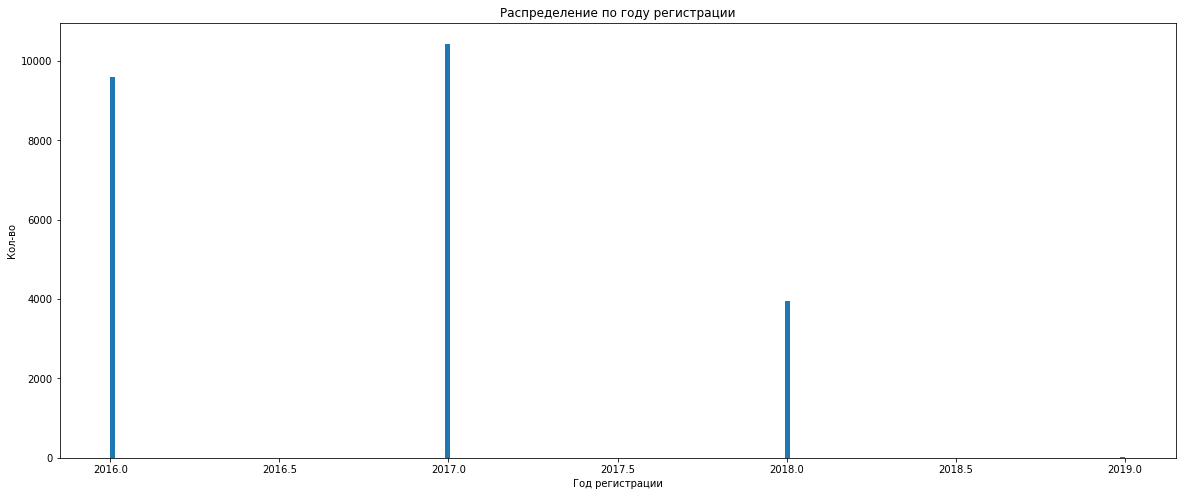

In [13]:
# построим гистограмму по мощности, чтобы посмотреть на выбросы
data[(data['RegistrationYear'] > 2015) & (data['RegistrationYear'] < 2022)]['RegistrationYear'].plot(kind='hist', bins=200, figsize=(20,8))
plt.title('Распределение по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во');

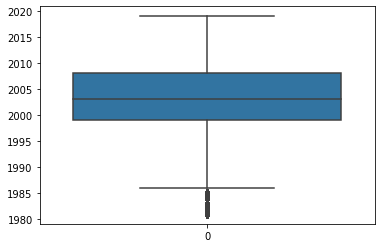

In [14]:
sns.boxplot(data=data[(data['RegistrationYear'] > 1980) & 
                      (data['RegistrationYear'] < 2022)]['RegistrationYear']);


удалим выбросы и строки с нулевыми значениями по цене

In [15]:
# удалим записи с нулевой ценой
data = data.loc[data['Price'] != 0]

In [16]:
# исключим записи с отсутствием модели
data = data.loc[~data['Model'].isna()]

In [17]:
# удалим выбросы по дате регистрации
data = data.query('RegistrationYear < 2016 and RegistrationYear >= 1950')

In [18]:
# заполним пропуски по наличию ремонта авто значением - unknown
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [19]:
# для мощности проведем следующую обработку пропусков и аномальных значений:
# для выбросов устанавливаем отсутствующие значения None
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
# заполняем пропуски средним значением из соответствующих моделей авто
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
# исключаем пропущенные значения, где не удолось посчитать мощность
data = data.loc[~data['Power'].isna()]
# меняем тип данных на целочисленный
data['Power'] = data['Power'].astype('int64')

In [20]:
# создадим список из столбцов для дальнейшей обработки пропусков
list_col = ['VehicleType','Gearbox', 'FuelType']

In [21]:
# с помощью цикла заполним пропуски наиболее частыми значениями по идентичным моделям авто
for col in list_col:
    data[col] = data[col].fillna(data.groupby('Model')['VehicleType']
                            .transform(lambda x: x.value_counts().idxmax()))

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306291 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             306291 non-null  int64 
 1   VehicleType       306291 non-null  object
 2   RegistrationYear  306291 non-null  int64 
 3   Gearbox           306291 non-null  object
 4   Power             306291 non-null  int64 
 5   Model             306291 non-null  object
 6   Kilometer         306291 non-null  int64 
 7   FuelType          306291 non-null  object
 8   Brand             306291 non-null  object
 9   NotRepaired       306291 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


In [23]:
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,sedan,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


**Выводы:**

в результате предобработки данных (с пропусками до 20%) удалось обработать и отсечь только 8% данных (включая 3% - объявления с нулевой ценой и 5% - объявления без указания модели авто, что непосредственно оказывает влияние на расчет цены), остальные выбросы и пропуски значений были обработаны без потери данных.

## Обучение моделей

### Кодирование данных

Данные подготовим методом OHE (прямой метод, который позволит все признаки сделать количественными), это позволит нам использовать модель линейной регрессии

In [24]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,101,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
# посмотрим размер данных
data_ohe.shape

(306291, 320)

In [26]:
# выделим в отдельный лист категориальные признаки
categorical_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [27]:
# изменим тип данных с object на category
for col in categorical_list:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306291 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             306291 non-null  int64   
 1   VehicleType       306291 non-null  category
 2   RegistrationYear  306291 non-null  int64   
 3   Gearbox           306291 non-null  category
 4   Power             306291 non-null  int64   
 5   Model             306291 non-null  category
 6   Kilometer         306291 non-null  int64   
 7   FuelType          306291 non-null  category
 8   Brand             306291 non-null  category
 9   NotRepaired       306291 non-null  category
dtypes: category(6), int64(4)
memory usage: 13.7 MB


**Вывод:** для возможности использования модели линейной регрессии применили метод Ohe, перекодировав категориальные признаки.

### Создание выборок

In [28]:
# создадим признаки для обучения модели линейной регрессии
features = data_ohe.drop(['Price'], axis = 1)
target = data_ohe['Price']

In [29]:
# разделим выборки на обучающую и тестовую для остальных моделей
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=12345)


In [30]:
# масштабируем выборки
scaler = StandardScaler()
scaler.fit_transform(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

По условию задания качество моделей будем определять метрикой RMSE. 
<br> Запишем функцию для расчета rmse.

In [31]:
def rmse (target, predictions):
    rmse =  mean_squared_error(target, predictions, squared= False)
    return rmse

**Вывод:** выборки подготовлены для обучения моделей

### Обучение моделей

#### Константная модель

In [32]:
constant_model = DummyRegressor(strategy='mean')
constant_model.fit(features_train,target_train)
constant_pred = constant_model.predict(features_test)
print('RMSE для константной модели:', rmse(target_test,constant_pred).round(2))

RMSE для константной модели: 4576.33


#### LinearRegression

In [33]:
model_lr = LinearRegression()

In [34]:
%%time
model_lr.fit(features_train, target_train)

CPU times: user 18.3 s, sys: 7.6 s, total: 25.9 s
Wall time: 27.3 s


LinearRegression()

In [35]:
%%time
predicted_lr = pd.Series(model_lr.predict(features_test))

CPU times: user 55.5 ms, sys: 39 ms, total: 94.5 ms
Wall time: 95.3 ms


In [36]:
print('RMSE - LinearRegression:', rmse(target_test, predicted_lr).round(2))

RMSE - LinearRegression: 2575.45


#### CatBoostRegressor

In [37]:
model_cbr = CatBoostRegressor(loss_function='RMSE', 
                              iterations=100, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=18, 
                              max_depth=10, 
                              l2_leaf_reg=3.5
                              )

In [38]:
%%time
model_cbr.fit(features_train, target_train)

0:	learn: 3919.6731600	total: 119ms	remaining: 11.8s
1:	learn: 3414.1948761	total: 184ms	remaining: 9.02s
2:	learn: 3035.8938979	total: 245ms	remaining: 7.92s
3:	learn: 2748.2977129	total: 306ms	remaining: 7.34s
4:	learn: 2538.5595134	total: 371ms	remaining: 7.04s
5:	learn: 2374.9484760	total: 434ms	remaining: 6.79s
6:	learn: 2239.5396233	total: 497ms	remaining: 6.6s
7:	learn: 2147.7151994	total: 561ms	remaining: 6.45s
8:	learn: 2070.2587662	total: 622ms	remaining: 6.29s
9:	learn: 2016.0361680	total: 687ms	remaining: 6.18s
10:	learn: 1970.4773898	total: 750ms	remaining: 6.07s
11:	learn: 1929.1597056	total: 814ms	remaining: 5.96s
12:	learn: 1900.1048477	total: 880ms	remaining: 5.89s
13:	learn: 1875.5751597	total: 944ms	remaining: 5.8s
14:	learn: 1856.7066443	total: 1.01s	remaining: 5.71s
15:	learn: 1840.2218563	total: 1.07s	remaining: 5.64s
16:	learn: 1825.8393179	total: 1.15s	remaining: 5.61s
17:	learn: 1813.5227566	total: 1.21s	remaining: 5.53s
18:	learn: 1800.4882925	total: 1.28s	rem

In [39]:
%%time
predict_cbr = model_cbr.predict(features_test, verbose = 2)

CPU times: user 63.6 ms, sys: 0 ns, total: 63.6 ms
Wall time: 61.9 ms


In [40]:
print('RMSE - CatBoostRegressor:', rmse(target_test, predict_cbr).round(2))

RMSE - CatBoostRegressor: 1628.31


#### LightGBM

In [41]:
parameters = {'boosting_type': 'gbdt', 
              'max_depth': 7,
              'n_estimators': 100, 
              'learning_rate': 0.2,
              'random_state': 12345}

In [42]:
model_lgbm = LGBMRegressor(**parameters)

In [43]:
%%time
model_lgbm.fit(features_train, target_train)

CPU times: user 16.8 s, sys: 408 ms, total: 17.2 s
Wall time: 17.3 s


LGBMRegressor(learning_rate=0.2, max_depth=7, random_state=12345)

In [44]:
%%time
predict_lgbm = model_lgbm.predict(features_test, verbose = 2)

CPU times: user 716 ms, sys: 49.8 ms, total: 766 ms
Wall time: 711 ms


In [45]:
print('RMSE - LGBMRegressor:', rmse(target_test, predict_lgbm).round(2))

RMSE - LGBMRegressor: 1645.18


#### DecisionTreeRegressor

In [46]:
for depth in range(5, 30, 5):
    model = DecisionTreeRegressor(max_depth=depth, splitter='best', random_state=12345, min_samples_split=2)
    mse = cross_val_score(model, features_train, target_train, cv=3, scoring='neg_mean_squared_error')
    print("RMSE при depth =", depth, ":", (-mse.mean()) ** 0.5)


RMSE при depth = 5 : 2344.813399766717
RMSE при depth = 10 : 1986.7162650268956
RMSE при depth = 15 : 1882.5260439414199
RMSE при depth = 20 : 1891.4496113729388
RMSE при depth = 25 : 1914.3189107263088


In [47]:
parameters = {'max_depth': 15,
              'random_state': 12345}

In [48]:
DTR_model = DecisionTreeRegressor(**parameters)

In [49]:
%%time
DTR_model.fit(features_train, target_train)

CPU times: user 5.33 s, sys: 62.9 ms, total: 5.4 s
Wall time: 5.4 s


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [50]:
%%time
predict_DTR = DTR_model.predict(features_test)

CPU times: user 50.1 ms, sys: 28.7 ms, total: 78.8 ms
Wall time: 81.7 ms


In [51]:
print('RMSE - DecisionTreeRegressor:', rmse(target_test, predict_DTR).round(2))

RMSE - DecisionTreeRegressor: 1838.51


## Анализ моделей

Сравним расчеты по каждой модели

In [53]:
models = [['LR', 27, 95, 2575], 
          ['CBR', 9, 62, 1628],
          ['LGB', 17, 711, 1645],
          ['DTR', 5, 82, 1839]] 
    
df = pd.DataFrame(models, columns =['model', 'train_time, sec', 'predict_time, msec', 'rmse']) 
df 


,model,"train_time, sec","predict_time, msec",rmse
0,LR,27,95,2575
1,CBR,9,62,1628
2,LGB,17,711,1645
3,DTR,5,82,1839


**Вывод:**
Глядя на результаты, можно сказать, что градиентный бустинг показывает лучше результаты, чем линейные модели. 
Лучшая модель - CatBoostRegressor и по метрике RMSE и по скорости обучения и предсказания.

## Вывод

**Общие выводы по проекту:**

В ходе проекта было сделано:
1. проведен анализ данных с выявлением аномалий, пропусков, которые в последствии были отработаны. 8% данных пришлось отбросить в связи с отсутствием информации по цене, либо модели авто.
2. Данные были подготовлены для обучения моделей (категориальные признаки были закодированы, созданы обучающая и тестовая выборки в отношении 75% и 25%)
3. Для обучения были выбраны 4 модели: `LinearRegression`, `CatBoostRegressor`, `LightGBM` и `DecisionTreeRegressor`, в которых были выставлены гиперпараметры с целью получения наилучшей метрики RMSE
4. Все модели получили RMSE лучше в сравнении с константной моделью, у которой RMSE = 4576
5. По сравнению результатов моделей можно сказать, что время предсказания любой модели значительно меньше, чем её обучение. К минимизации времени предсказания нужно стремиться, т.к. модель обучается 1 раз, а предсказывать она может множество раз не переобучиваясь.
6. Лушие показатели дала модель `CatBoostRegressor` со значением RMSE = 1628 (что значительно лучше константной модели), ее и рекомендуется выбрать для предсказания цен авто.